# Creating baseline performance for CanESM on SOCAT


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
#import hvplot.xarray
import sys

%matplotlib inline

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

sys.path.insert(0, '../../src')

from utils import df_to_xarray,read_xarray

import statsmodels
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib import pyplot


print('statsmodels: %s' % statsmodels.__version__)

/burg/glab/users/jn2808/ocean_co2/env/lib/python3.8/site-packages/xarray/backends/cfgrib_.py:27: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(
2024-07-10 23:26:22.570997: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cm/shared/apps/slurm/current/lib64/slurm:/cm/shared/apps/slurm/current/lib64
2024-07-10 23:26:22.571033: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


statsmodels: 0.14.1


In [2]:
can_data_path = "../../data/can_001"

def read_xarray_can(dir_name=""):
    '''
     read_xarray(dir)name) opens data and returns data in xarray format for each feature mpi
    '''
    date="198201-201712"
  
    file_type ="CanESM2r1r10"
    #Chl_2D_mon_CanESM2r1r10_1x1_198201-201712.nc
        
    chl = xr.open_dataset(f'{dir_name}/Chl_2D_mon_{file_type}_1x1_{date}.nc')

    mld = xr.open_dataset(f'{dir_name}/MLD_2D_mon_{file_type}_1x1_{date}.nc')

    sss = xr.open_dataset(f'{dir_name}/SSS_2D_mon_{file_type}_1x1_{date}.nc')

    sst = xr.open_dataset(f'{dir_name}/SST_2D_mon_{file_type}_1x1_{date}.nc')

    xco2 = xr.open_dataset(f'../../data/member_001/XCO2_1D_mon_CESM001_native_198201-201701.nc')

    pco2 = xr.open_dataset(f'{dir_name}/pCO2_2D_mon_{file_type}_1x1_{date}.nc')

    return chl,mld,sss,sst,xco2,pco2


chl,mld,sss,sst,xco2,pco2 = read_xarray_can(can_data_path)

xco2=xco2.isel(bnds=1)
xco2['time'] = xco2.indexes['time'].to_datetimeindex().strftime("%Y-%m")


/burg/glab/users/jn2808/ocean_co2/env/lib/python3.8/site-packages/xarray/backends/plugins.py:61: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)
/local/ipykernel_4006853/2288182462.py:30: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  xco2['time'] = xco2.indexes['time'].to_datetimeindex().strftime("%Y-%m")


In [3]:
pco2 = pco2.isel(bnds=1)
mld = mld.isel(bnds=1)
sss = sss.isel(bnds=1)
sst = sst.isel(bnds=1)

In [4]:
pco2['time'] = pco2.time.dt.strftime("%Y-%m")
chl['time'] = chl.time.dt.strftime("%Y-%m")
mld['time'] =mld.time.dt.strftime("%Y-%m")
sss['time'] =sss.time.dt.strftime("%Y-%m")
sst['time'] =sst.time.dt.strftime("%Y-%m")

data_read=xr.merge([chl.Chl,chl.Chl_socat,mld.MLD,mld.MLD_socat,sst.SST,sst.SST_socat,
                    sss.SSS,sss.SSS_socat,xco2,pco2.pCO2,pco2.pCO2_socat])
tmp_data=data_read.to_dataframe().reset_index()

tmp_data=tmp_data.drop(columns=['TLONG', 'TLAT', 'time_bnds'])


In [5]:
tmp_data_final=tmp_data[tmp_data.time != "2017-01"]
tmp_data_final=tmp_data_final[tmp_data_final.time != "2017-02"]

In [6]:
features_socat = ['time','xlon', 'ylat', 'SST_socat', 'SSS_socat','Chl_socat', 'XCO2','pCO2_socat']
features = ['time','xlon', 'ylat','SST','SSS','Chl','XCO2','pCO2']

# create separate dataframe for socat
combined_socat=tmp_data[features_socat]
combined=tmp_data[features]

In [7]:
# drop rows where pco2 or pco2_socat == NA or 0
combined_socat.dropna(subset = ["pCO2_socat","SST_socat","XCO2"],inplace=True)
combined_socat= combined_socat[combined_socat['pCO2_socat']!=0]
combined.dropna(subset = ["pCO2","SST","XCO2"],inplace=True)
combined= combined[combined['pCO2']!=0]

/burg/glab/users/jn2808/ocean_co2/env/lib/python3.8/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [8]:
X_socat=combined_socat.iloc[:,3:-1]
X=combined.iloc[:,3:-1]
y=combined.loc[:,'pCO2']
y_socat=combined_socat.loc[:,'pCO2_socat']

In [9]:
X_socat.shape[0]/X.shape[0]*100

1.390008248745232

In [10]:
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy='mean')

X=imp.fit_transform(X)
X_socat=imp.fit_transform(X_socat)

In [11]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

X_train, X_test, y_train, y_test = train_test_split(X_socat, y_socat, test_size=0.4, random_state= 73)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state= 73)


regressor=RandomForestRegressor(n_estimators=20,max_depth=10,random_state=50,n_jobs=-1)
regressor.fit(X_train, y_train)


forest_scores = cross_val_score(regressor, X_test, y_test,
                                scoring="neg_mean_squared_error", cv=3)
forest_rmse_scores = np.sqrt(-forest_scores)

display_scores(forest_rmse_scores)

Scores: [29.1455213  25.91766778 25.89380649]
Mean: 26.98566519025032
Standard deviation: 1.5272799680775928


In [13]:
# On Socat
y_pred=regressor.predict(X_socat)
test_mse=mean_squared_error(y_socat, y_pred,squared=True)
np.sqrt(test_mse)

25.98302758095115

In [12]:
## The whole grid
y_pred=regressor.predict(X)
final_test_rmse=np.sqrt(mean_squared_error(y, y_pred,squared=True))
error=y-y_pred
final_test_rmse

36.31125259795206

In [14]:

## Socat 
# train rmse :  25.92 uatm
# extrapolation rmse: on 36.36

In [15]:
combined["residual"] = error
combined["pred"] = y_pred

combined_tmp=combined.set_index(["time","ylat","xlon"])
result_data=combined_tmp[["residual"]]
result_data = result_data.sort_index()

combined_tmp=combined.set_index(["time","ylat","xlon"])
pred_data=combined_tmp[["pred","pCO2"]]
pred_data = pred_data.sort_index()

ds = result_data.to_xarray()
ds_pred = pred_data.to_xarray()

(array([1.0700000e+02, 1.6850000e+03, 5.1427000e+04, 1.5225866e+07,
        1.5479060e+06, 4.0273000e+04, 1.7279000e+04, 6.3730000e+03,
        3.5940000e+03, 2.1330000e+03, 1.1810000e+03, 6.4800000e+02,
        3.7000000e+02, 2.0300000e+02, 1.6600000e+02, 8.8000000e+01,
        5.2000000e+01, 4.9000000e+01, 2.9000000e+01, 2.9000000e+01,
        2.0000000e+01, 1.1000000e+01, 1.4000000e+01, 6.0000000e+00,
        8.0000000e+00, 7.0000000e+00, 8.0000000e+00, 3.0000000e+00,
        1.0000000e+00, 4.0000000e+00]),
 array([-484.51098131, -356.90462958, -229.29827786, -101.69192614,
          25.91442558,  153.52077731,  281.12712903,  408.73348075,
         536.33983247,  663.9461842 ,  791.55253592,  919.15888764,
        1046.76523936, 1174.37159109, 1301.97794281, 1429.58429453,
        1557.19064625, 1684.79699797, 1812.4033497 , 1940.00970142,
        2067.61605314, 2195.22240486, 2322.82875659, 2450.43510831,
        2578.04146003, 2705.64781175, 2833.25416348, 2960.8605152 ,
        

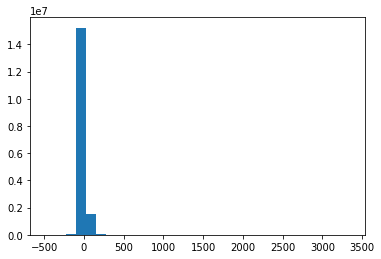

In [16]:
plt.hist(error,bins=30)

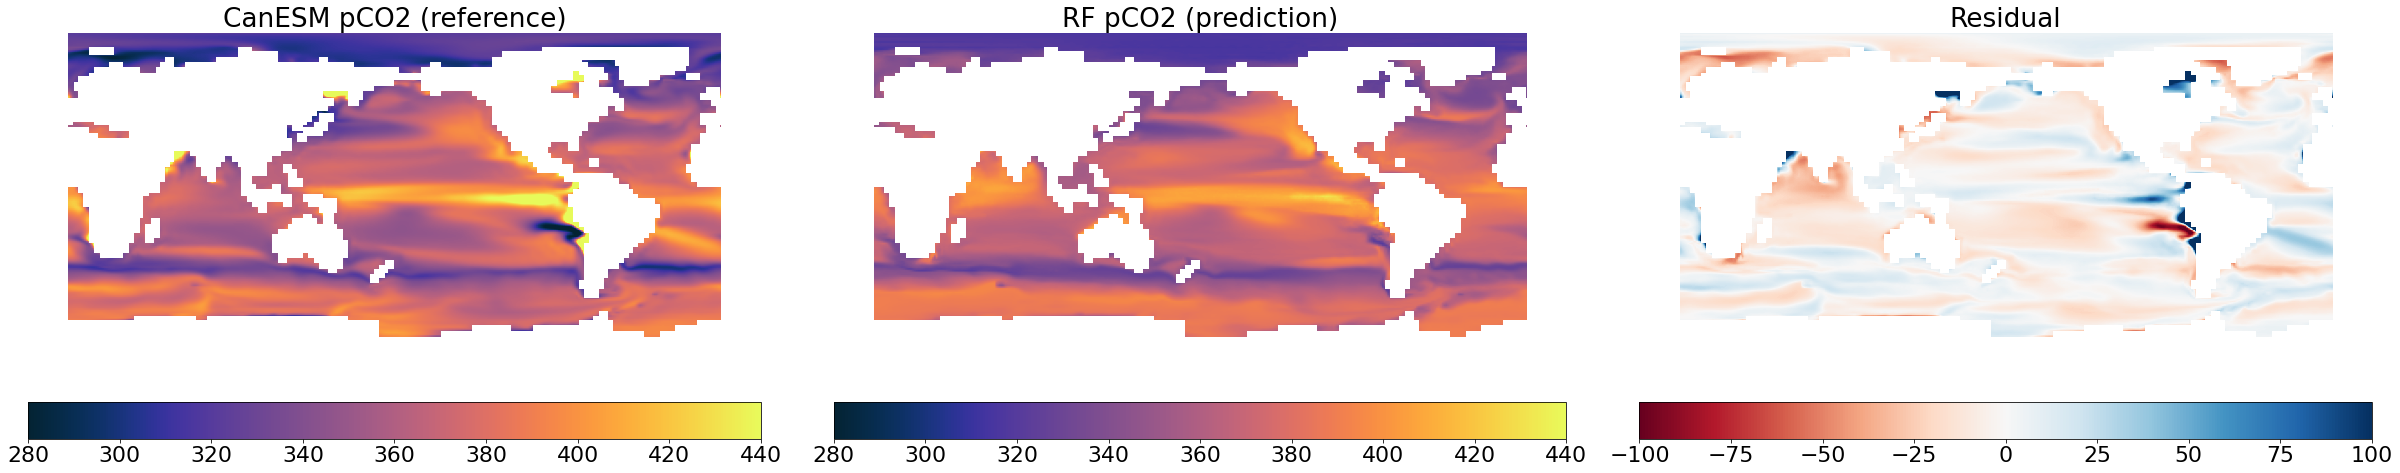

In [18]:
import matplotlib.colors as mcolors
import cmocean as cm


plt.rcParams.update({'font.size': 22})
norm = mcolors.Normalize(vmin=280, vmax = 440)

figure, axis = plt.subplots(1, 3,figsize=(42, 8))

im0 = axis[0].imshow(np.flipud(ds_pred.pCO2.mean('time').data),cmap = cm.cm.thermal,norm=norm)
cbar0 = figure.colorbar(im0, ax=axis[0], orientation='horizontal')
axis[0].set_title("CanESM pCO2 (reference)")
axis[0].axis('off')

im1 = axis[1].imshow(np.flipud(ds_pred.pred.mean('time').data),cmap = cm.cm.thermal,norm=norm)
cbar1 = figure.colorbar(im1, ax=axis[1], orientation='horizontal')
axis[1].set_title("RF pCO2 (prediction)")
axis[1].axis('off')


norm2 = mcolors.TwoSlopeNorm(vmin=-100, vmax = 100, vcenter=0)

im2 = axis[2].imshow(np.flipud(ds.residual.mean('time').data),cmap = "RdBu",norm=norm2)
cbar2 = figure.colorbar(im2, ax=axis[2], orientation='horizontal')
axis[2].set_title("Residual")
axis[2].axis('off')

plt.subplots_adjust(wspace=0.1)
# figure.suptitle("Average canESM RF pCO2 | Prediction | Residual - 1987/02-2017/01")
plt.savefig("../../assets/figure6.0_rf_canESM.jpg", dpi=200)

In [35]:
np.min(y)

110.78919219970703

In [36]:
np.percentile(y,10),np.percentile(y,90)

(310.09051513671875, 409.165380859375)

In [37]:
combined_tmp.reset_index(inplace=True)
avg_time=combined_tmp.groupby(by="time").mean()
avg_time_res = avg_time["residual"]

statsmodels: 0.13.5


/burg/glab/users/sk4973/venv2/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


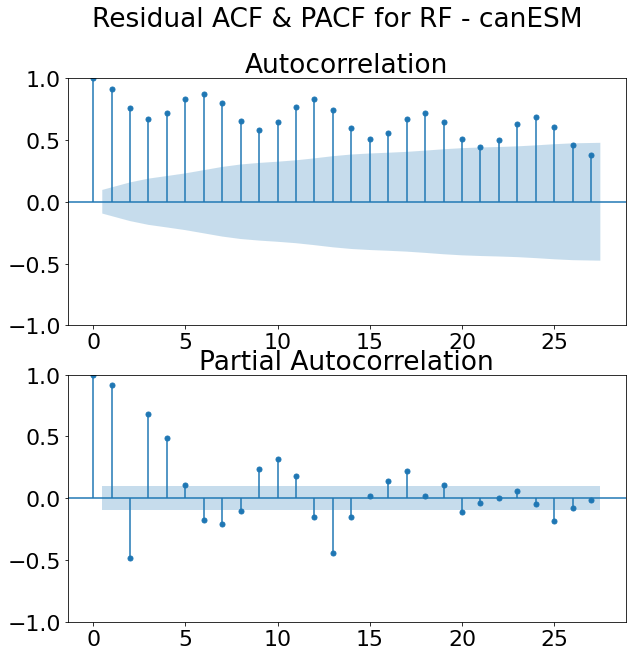

In [38]:
import statsmodels
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib import pyplot


print('statsmodels: %s' % statsmodels.__version__)
fig = pyplot.figure(figsize = (10,10))
pyplot.subplot(211)
plot_acf(avg_time_res, ax=pyplot.gca())
pyplot.subplot(212)
plot_pacf(avg_time_res, ax=pyplot.gca())

fig.suptitle("Residual ACF & PACF for RF - canESM")

#plt.savefig("../../assets/figure6.1_rf_canESM_acf.jpg")
pyplot.show()